________________________________________________________________________________________________________________

#### ***Problem Statement :***

    To explore curve fitting (best fit) to each volume-time curve and extract coefficients for each curve.
_________________________________________________________________________________________________________________

### ***Approach :***


***1. Curve fitting using the following function - 
$f(x) = a\ln(|x^2+bx+c|) + \frac{2(d-ab)}{\sqrt{4c-b^2}}tan^{-1}{\frac{2x+b}{\sqrt{4c-b^2}}} + e$***

***2. Curve fitting using Polynomial Regression***

***3. Curve fitting using Neural Network***
        
        
***Goodness of fit :*** *Mean Absolute Error is used to check goodness of the fit (Maximum, Minimum and Average of MAE)*

_________________________________________________________________________________________________________________
    

#### --------------------------------------------------------<i>Code</i>--------------------------------------------------------

### ***Importing Libraries***

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.optimize import curve_fit

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

### ***Reading Data***

In [2]:
data = pd.read_csv(r"C:\Users\khaitan\Documents\Assignment_InputData.csv", index_col=0)

In [3]:
data.head(3)

,VT_0,VT_1,VT_2,VT_3,VT_4,VT_5,VT_6,VT_7,VT_8,VT_9,...,VT_140,VT_141,VT_142,VT_143,VT_144,VT_145,VT_146,VT_147,VT_148,VT_149
INSTANCE,,,,,,,,,,,,,,,,,,,,,
1,0,0,240,690,1120,1470,1760,1980,2150,2280,...,3670,3670,3670,3670,3670,3670,3670,3670,3670,3670
2,0,0,30,200,420,550,650,740,810,880,...,2550,2550,2560,2560,2570,2570,2570,2580,2580,2590
3,0,0,10,60,180,280,350,410,470,550,...,1900,1900,1890,1890,1890,1890,1890,1890,1890,1890


### ***Visualizing the Data***

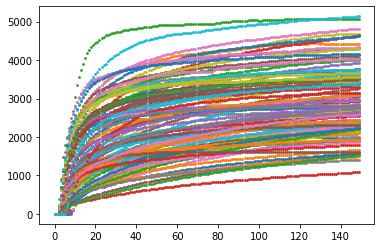

In [147]:
from matplotlib import pyplot as plt
for i in range(data.shape[0]):
    plt.scatter(range(150),list(data.loc[i+1]), s= 3)
plt.show()

*Visualizing the data gives us some idea about the curve. For example - A function of type $f(x) =\ \frac{a}{b+e^{c\left(x-d\right)}}$ can be used to approximate the curve. But we need to do some analysis as every function of this type of shape won't be able to approximate all the curves well.*

#### ------------------------------------------------ ***Method 1***  -------------------------------------------------------

#### ***Ploting derivative to get a sense of some curve that may work***

In [97]:
def plot_derivative(i, df):
    row = df.loc[i]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2))
    ax1.plot(row.values)
    ax1.set_title('Original curve')

    ax2.plot([row[f'VT_{j+1}'] - row[f'VT_{j}'] for j in range(len(row)-1)])
    ax2.set_title('Derivative curve')
    plt.show()

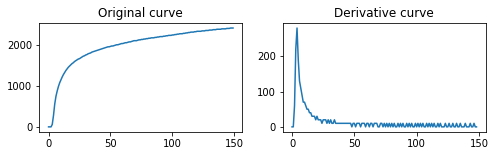

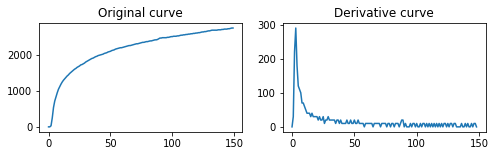

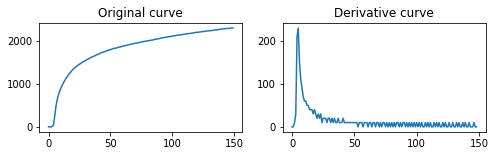

In [98]:
## Plotting the actual curve and the derivative (Randomly picking few curves) 

for i in range(3):
    a = random.choice(range(1,101))
    plot_derivative(a, data)

#### ***Plotting one function which has same kind of shape***

In [17]:
def func(x, a, b, c, d):
    c += (b/2)**2
    return (a*x+d)*np.reciprocal(x**2 + b*x + c)

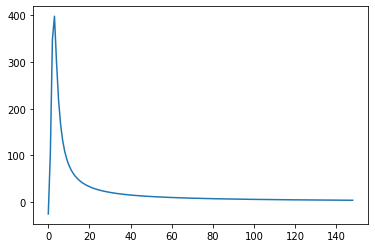

In [18]:
np.random.seed(23)
row = data.loc[random.choice(range(1,101))]
diff = [row[f'VT_{j+1}'] - row[f'VT_{j}'] for j in range(len(row)-1)]
popt, pcov = curve_fit(func, np.arange(149, dtype="float"), diff)
plt.plot(reciprocal(np.arange(149), *popt))

**Since the function defined above looks more or less like the derivative of the original function, it's worth trying to fit it's itegral on the data.**

***Derivative Function - $f'(x) = \frac{ax+d}{x^2+bx+c}$*** 

*By integrating the function we get -*

$\int f'(x) =  f(x) = a\ln(|x^2+bx+c|) + \frac{2(d-ab)}{\sqrt{4c-b^2}}tan^{-1}{\frac{2x+b}{\sqrt{4c-b^2}}} + e$

#### ***Defining integral function***

In [187]:
def integral_rec(x, a, b, c, d, e):
    c = (b/2)**2 + np.abs(c)
    temp = 1/np.sqrt(4*c - b**2)
    return a*np.log(np.abs(x**2 + b*x + c)) + 2*(d - a*b)*temp*np.arctan((2*x + b)*temp) + e

## Same function but with d = 0
def integral_rec_d0(x, a, b, c, e): 
    c = (b/2)**2 + np.abs(c)
    temp = 1/np.sqrt(4*c - b**2)
    return a*np.log(np.abs(x**2 + b*x + c)) + 2*(- a*b)*temp*np.arctan((2*x + b)*temp) + e
    

#### ***Fitting the Curve, extracting coefficients, making predictions, Calculating Error***

In [193]:
Errors_mse = []  # Keeps the Mean Square Error for each V-T data
Errors_mae = []  # Keeps the Mean Absolute Error for each V-T data
Params = {}      # Keeps the coefficients for each each V-T data
Predictions = {} # Keeps the predictions

fitted_with_d0 = []
not_fitting = []

xdata = np.arange(data.shape[1], dtype="float")

for index, row in data.iterrows():
    ydata = row.to_numpy()
    try:
        popt, _ = curve_fit(integral_rec, xdata=xdata, ydata=ydata)
        Params[index] = tuple(popt)
    except:
        try:
            (a, b, c, e), _ = curve_fit(integral_rec_d0, xdata=xdata, ydata=ydata)
            Params[index] = (a, b, c, 0, e)
            fitted_with_d0.append(index)
        except:
            not_fitting.append(index)
            continue
    
    ypred = integral_rec(xdata, *popt)
    Predictions[index] = ypred
    
    Errors_mse.append((index, mean_squared_error(y_true=ydata, y_pred=ypred)))
    Errors_mae.append((index,mean_absolute_error(ydata, ypred)))

***Checking Goodness of fit***

In [217]:
errors_mae_not_d0 = [e for (i, e) in Errors_mae if i not in fitted_with_d0]
print(F"With coefficient d not equal to zero:\n\n\t\tmax:{max(errors_mae_not_d0)}\n\t\tmin:{min(errors_mae_not_d0)}\n\t\tavg:{np.mean(errors_mae_not_d0)}")
errors_mae_d0 = [e for (i, e) in Errors_mae if i in fitted_with_d0]
print("\nErrors with d=0:", errors_mae_d0)
print ("-"*100)

With coefficient d not equal to zero:

		max:127.79579301852299
		min:3.937854763210588
		avg:14.459669503255867

Errors with d=0: [1347.0121071731385, 1132.8717709530654, 153.3085430936256, 495.5375382171566]
----------------------------------------------------------------------------------------------------


### ***Visualizing few predictions (Randomly selected)***

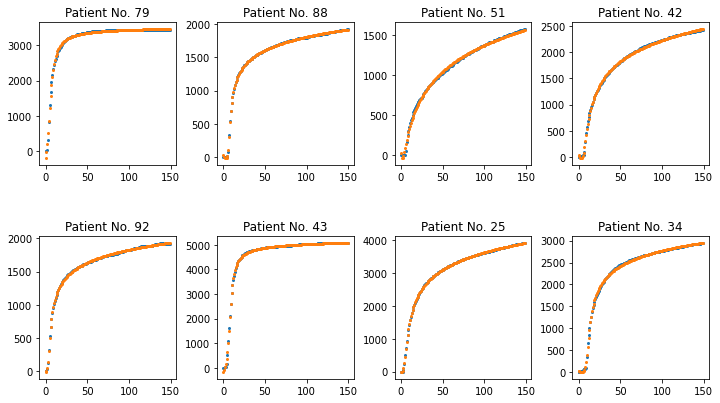

In [239]:
row = 2
col = 4

fig, axs = plt.subplots(row, col, figsize=(12,5))
fig.subplots_adjust(top = 1, bottom= 0.01, hspace=0.5, wspace=0.3)

for i in range(row):
    for j in range(col):
        r = random.choice(list(Predictions.keys()))
        #print("Random pick: Patient ",r)
        axs[i,j].scatter(xdata, data.loc[r], s=4)
        axs[i,j].scatter(xdata, Predictions[r], s=4)
        axs[i,j].set_title("Patient No. {}".format(r))
plt.show() 

### ***Plotting the Coefficients for all curves***

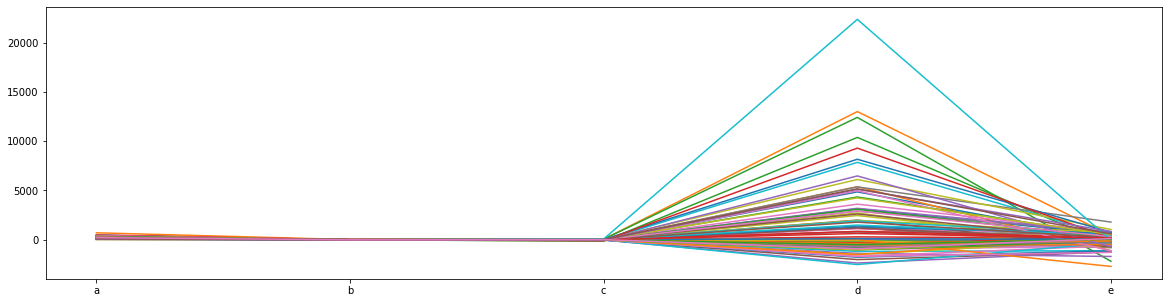

In [258]:
## We have 5 coefficients in the function

plt.figure(figsize=(20,5))

for i in Predictions.keys():
    plt.xticks(range(5),["a","b","c","d","e"])
    plt.plot(Params[i])
plt.show()

#### *Performance of the function -*

    1. The function didn't fit on some V-T data. 
    2. On some V-T data, the function worked with d (one of the coefficient involved in the function) = 0 but MAE is high.
    3. The function worked well for other 80-85 patients data.

    Though it worked well on most of the patient data, it didn't even fit on some. So other methods were tried out.


#### --------------------------------------------------- ***Method 2***  ------------------------------------------------------

### ***Using Polynomial Regression***

In [35]:
## Polynomial of degree 7 

def polynomial_reg_fit(xdata, ydata, degree = 7):
    
    poly_reg = PolynomialFeatures(degree)
    X_poly = poly_reg.fit_transform(np.array(xdata).reshape(-1,1))
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, ydata)
    y_pred = lin_reg.predict(X_poly)
    coefficients = lin_reg.coef_
    return y_pred, coefficients

#### ***Fitting the Curve, extracting coefficients, making predictions, Calculating Error***

In [208]:
errors_mse = []  # Keeps the Mean Square Error for each V-T data
errors_mae = []  # Keeps the Mean Absolute Error for each V-T data
params = []      # Keeps the coefficients for each each V-T data
predictions = [] # Keeps the predictions

xdata = np.arange(data.shape[1], dtype="float")

for index, row in data.iterrows():
    
    ydata = row.to_numpy()
    ypred, coefficients = polynomial_reg_fit(xdata, ydata)
    
    predictions.append(ypred)
    params.append(coefficients)
    errors_mse.append(mean_squared_error(y_true=ydata, y_pred=ypred))
    errors_mae.append(mean_absolute_error(ydata, ypred))

***Checking Goodness of fit***

In [209]:
print("Maximum Mean Absolute Error:", max(errors_mae))
print("Minimum Mean Absolute Error:", min(errors_mae))
print("Average Mean Absolute Error:", np.mean(errors_mae))

Maximum Mean Absolute Error: 85.5980104880394
Minimum Mean Absolute Error: 3.833314877152286
Average Mean Absolute Error: 22.96612544097715


### ***Visualizing few predictions (Randomly selected)***

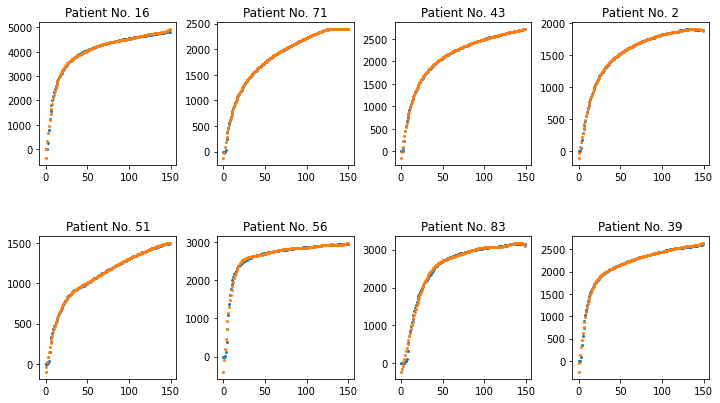

In [244]:
row = 2
col = 4

fig, axs = plt.subplots(row, col, figsize=(12,5))
fig.subplots_adjust(top = 1, bottom= 0.01, hspace=0.5, wspace=0.3)

for i in range(row):
    for j in range(col):
        r = random.choice(range(100))
        axs[i,j].scatter(xdata, data.iloc[r], s=4)
        axs[i,j].scatter(xdata, predictions[r], s=4)
        axs[i,j].set_title("Patient No. {}".format(r))
plt.show()

#### ***Visualizing prediction with minimum and maximum Mean Absolute Error***

Text(0.5, 1.0, 'Maximum Error')

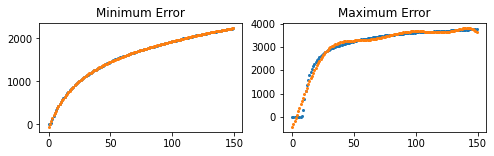

In [152]:
ind_min = errors_mae.index(min(errors_mae))
ind_max = errors_mae.index(max(errors_mae))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2))
ax1.scatter(xdata, data.iloc[ind_min], s=4)
ax1.scatter(xdata, predictions[ind_min], s=4)
ax1.set_title('Minimum Error')

ax2.scatter(xdata, data.iloc[ind_max], s=4)
ax2.scatter(xdata, predictions[ind_max], s=4)
ax2.set_title('Maximum Error')

### ***Plotting the Coefficients for all curves***

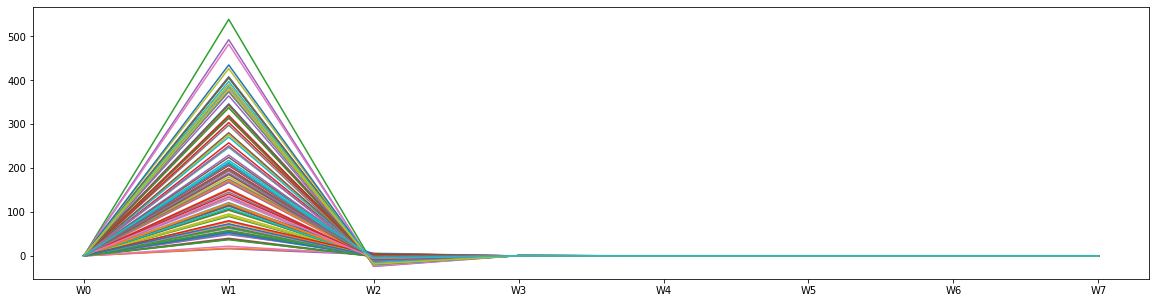

In [257]:
## We have 8 coefficients in the function

plt.figure(figsize=(20,5))
for i in range(100):
    plt.xticks(range(8),["W{}".format(i) for i in range(8)])
    plt.plot(params[i])
plt.show()

    Polynomial regression is one of the best choice when we have non linear data. We can try polynomial of any degree. In our case Polynomial of degree 7 gives the minimum average MAE.

#### -------------------------------------------------- ***Method 3***  ------------------------------------------------------

### ***Using Neural Network***

    We know that Neural Networks can be used as Function Approximation Algorithms as it can learn any complicated function. Here the Architechture of the network is important. We can use many layers and as many nodes in a layer as we want but it will increase the number of parameters which will be learned during backpropagation. We are interested on these learnable parameters.

    Here we want the best posssible curve fit but at the same time using complicated architecture(same as involving many paramters) may effect our goal. So it is preferable to use Vanilla Neural Network Architechture which won't involve large no of parameters but will be able to approximate the curve. We need to train the model for large no of epochs for the parameter values to converge. Even if we use slightly complicated Neural Network architechture, we need to do some analysis on the learned coefficients so that any V-T data can be differentiated based on the coefficients.

#### ***Preparing data, Building Model***

In [77]:
#### Defining Necessary functions 

def transform_data(x,y):

    # Reshaping arrays 
    x = x.reshape((len(x), 1))
    y = y.reshape((len(y), 1))

    # Scaling the input and output variables
    scale_x = MinMaxScaler()
    transformed_x = scale_x.fit_transform(x)
    scale_y = MinMaxScaler()
    transformed_y = scale_y.fit_transform(y)

    return(transformed_x, transformed_y, scale_x, scale_y)


def nn_model(x, y, epochs = 1000):
    
    # Defining Model
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(5, input_dim=1, activation='sigmoid'))
    # model.add(Dense(2, activation='sigmoid'))
    
    # Output Layer
    model.add(Dense(1))
    
    # Loss function and optimization algorithm
    model.compile(loss='mse', optimizer='adam')
    
    # Fitting the model on the training dataset
    model.fit(x, y, epochs= epochs, batch_size=1, verbose=0)

    return model


def inverse_transform(t_x, t_y, yhat, scale_x, scale_y):
    
    # Converting back to main scale
    inv_tx= scale_x.inverse_transform(t_x)
    inv_ty = scale_y.inverse_transform(t_y)
    inv_yhat = scale_y.inverse_transform(yhat)

    return(inv_tx, inv_ty, inv_yhat)

#### ***Fitting the Curve, extracting coefficients, making predictions, Calculating Error***

In [78]:
MAE_list = []        # Keeps the Mean Square Error for each V-T data
MSE_list = []        # Keeps the Mean Absolute Error for each V-T data
nn_params = []       # Keeps the coefficients for each each V-T data
nn_predictions = []  # Keeps the predictions


x_true = np.array(range(0,150),dtype=np.float)

for i in range(100):

    y_true = np.array(data.iloc[i])
    tx, ty, scale_x, scale_y = transform_data(x_true,y_true)
    model = nn_model(tx, ty)
    yhat = model.predict(tx)
    x, y, yhat = inverse_transform(tx, ty, yhat, scale_x, scale_y)

    MAE = mean_absolute_error(y_true, yhat)
    MAE_list.append(MAE)
    
    nn_params.append(model.get_weights())
    nn_predictions.append(yhat)
    keras.backend.clear_session()
    
    print("Fitted for Dataset ", i+1)
    print("MAE: ", MAE)

Fitted for Dataset  1
MAE:  25.515169881184896
Fitted for Dataset  2
MAE:  12.688484001159669
Fitted for Dataset  3
MAE:  7.517737477620443
Fitted for Dataset  4
MAE:  28.731151682535806
Fitted for Dataset  5
MAE:  27.001071713765462
Fitted for Dataset  6
MAE:  25.37325122833252
Fitted for Dataset  7
MAE:  15.102168299357096
Fitted for Dataset  8
MAE:  38.44555501302084
Fitted for Dataset  9
MAE:  23.209457244873047
Fitted for Dataset  10
MAE:  17.139416879018146
Fitted for Dataset  11
MAE:  23.209616266886393
Fitted for Dataset  12
MAE:  46.01276865005493
Fitted for Dataset  13
MAE:  7.824889895121257
Fitted for Dataset  14
MAE:  22.45274454752604
Fitted for Dataset  15
MAE:  12.83133518854777
Fitted for Dataset  16
MAE:  14.629505360921224
Fitted for Dataset  17
MAE:  35.61260834058126
Fitted for Dataset  18
MAE:  7.304733753204346
Fitted for Dataset  19
MAE:  13.485780029296874
Fitted for Dataset  20
MAE:  45.91375
Fitted for Dataset  21
MAE:  20.117984263102212
Fitted for Dataset  

##### ***Checking goodness of fit***

In [79]:
print("Maximum Mean Absolute Error:", max(MAE_list))
print("Minimum Mean Absolute Error:", min(MAE_list))
print("Average Mean Absolute Error:", np.mean(MAE_list))

Maximum Mean Absolute Error: 72.34045903523763
Minimum Mean Absolute Error: 4.989880771636963
Average Mean Absolute Error: 24.29620614931584


### ***Visualizing few predictions (Randomly selected)***

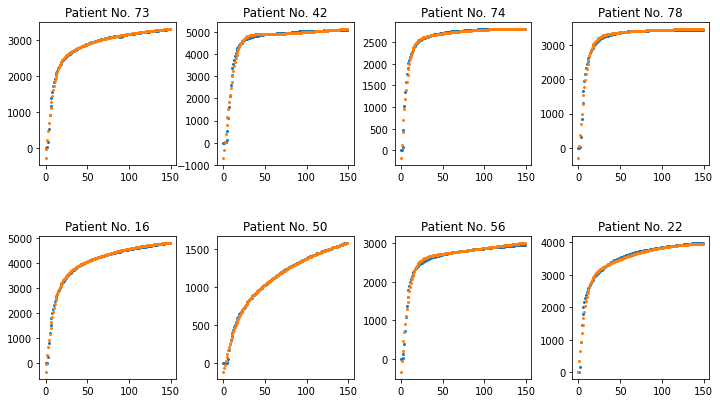

In [259]:
row = 2
col = 4

fig, axs = plt.subplots(row, col, figsize=(12,5))
fig.subplots_adjust(top = 1, bottom= 0.01, hspace=0.5, wspace=0.3)

for i in range(row):
    for j in range(col):
        r = random.choice(range(100))
        axs[i,j].scatter(xdata, data.iloc[r], s=4)
        axs[i,j].scatter(xdata, nn_predictions[r], s=4)
        axs[i,j].set_title("Patient No. {}".format(r))

plt.show()

#### ***Visualizing prediction with minimum and maximum Mean Absolute Error***

Text(0.5, 1.0, 'Maximum Error')

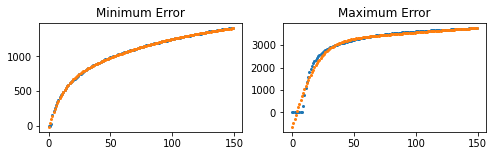

In [156]:
index_min = MAE_list.index(min(MAE_list))
index_max = MAE_list.index(max(MAE_list))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2))
ax1.scatter(xdata, data.iloc[index_min], s=4)
ax1.scatter(xdata, nn_predictions[index_min], s=4)
ax1.set_title('Minimum Error')

ax2.scatter(xdata, data.iloc[index_max], s=4)
ax2.scatter(xdata, nn_predictions[index_max], s=4)
ax2.set_title('Maximum Error')

### ***Plotting the coefficients for all curves***

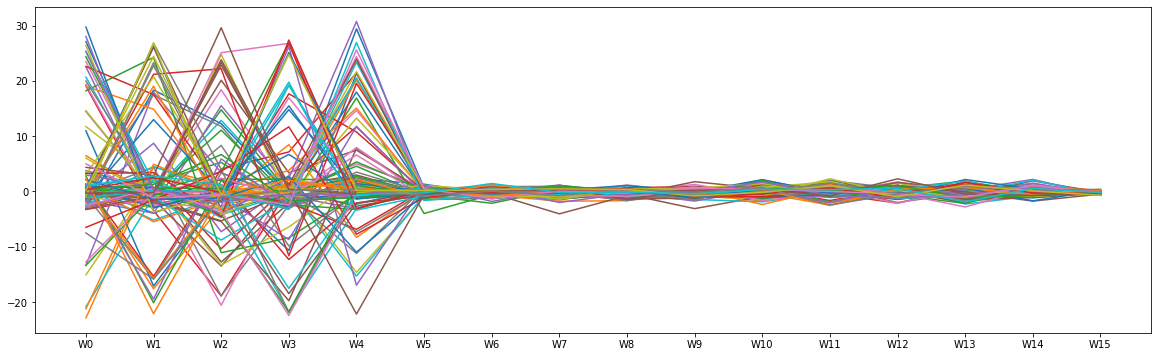

In [254]:
## We have 16 coefficients 

plt.figure(figsize=(20,6))
for i in range(100):
    x = nn_params[i]
    a = np.concatenate([x[j].flatten() for j in range(len(x))], axis= 0)
    plt.xticks(range(16),["W{}".format(i) for i in range(16)])
    plt.plot(a)
plt.show()

##### ***Following changes can be made in the architechture -***

    - Increasing the no of nodes and/or no of layers
    - Changing the activation functions
    - Instead of passing x(timepoints) as input, we can pass x and/or x^2 and/or some function of x


#### **Conclusion:**

    The function used in the first method gives small Mean Absolute Error but doesn't fit on all the V-T data whereas the other two methods don't face that issue. The other two methods were able to identify the pattern for each of the V-T data. In case of Neural Network, We have a scope of decresing the MAE significantly by using some different architechture which will involve large no of parameters. Even this vanilla NN has 16 learnable parameters. We can use some other architechture but we need to do further analysis on the values of the learnable parameters(to obtain some criterion) to differentiate the curves based on that.